In [1]:
import pandas as pd
import numpy as np

# Import file
df_mcm = pd.read_csv('Wimbledon_featured_matches.csv')

In [2]:
# Splitting MCM data into data frames for each match

# Splitting match_id and extracting suffix
df_mcm['match_id_suffix'] = df_mcm['match_id'].apply(lambda x: x.split('-')[-1])

# Finding unique suffix values
unique_suffixes = df_mcm['match_id_suffix'].unique()

# Dictionary to store new data frames
match_id_dfs = {}

# Iterating over unique suffixes and creating separate data frames
for suffix in unique_suffixes:
    # Filtering rows based on current suffix and creating a copy
    match_id_dfs[suffix] = df_mcm[df_mcm['match_id_suffix'] == suffix].copy(deep=True)

# Match id's go from 1301 to 1702 but not all of them
for i in range(1301, 1702):
    example_suffix = str(i)
    if example_suffix in match_id_dfs:
        globals()[f"df_{example_suffix}"] = match_id_dfs[example_suffix]
    else:
        pass


In [3]:
# List of DataFrame names
df_names = [f'df_{i}' for i in unique_suffixes]

In [4]:
# Function to determine the winner of a match
def determine_winner(match_row):
    if match_row['p1_sets'] > match_row['p2_sets']:
        return 1
    elif match_row['p1_sets'] < match_row['p2_sets']:
        return 2
    else:
        return 1 if match_row['game_victor'] == 1 else 2

# Function to calculate performance metrics
def calculate_performance_metrics(match_data):
    match_data['SWP_1'] = np.where(match_data['set_no'] == 0, 0, match_data['p1_sets'] / match_data['set_no'])
    match_data['SWP_2'] = np.where(match_data['set_no'] == 0, 0, match_data['p2_sets'] / match_data['set_no'])
    
    # Initialize new columns with zeros
    match_data['PWP_1'] = 0
    match_data['PWP_2'] = 0

    # Get unique game numbers
    unique_games = match_data['game_no'].unique()

    # Loop through each game and calculate PWP
    for game in unique_games:
        game_data = match_data[match_data['game_no'] == game]
        p1_points_won = 0
        p2_points_won = 0
        
        for i in game_data.index:
            if game_data.at[i, 'point_victor'] == 1:
                p1_points_won += 1
            elif game_data.at[i, 'point_victor'] == 2:
                p2_points_won += 1
            
            total_points = p1_points_won + p2_points_won
            if total_points != 0:
                match_data.at[i, 'PWP_1'] = p1_points_won / total_points
                match_data.at[i, 'PWP_2'] = p2_points_won / total_points
    
    
    # Initialize new columns with zeros
    match_data['GWP_1'] = 0
    match_data['GWP_2'] = 0

    # Get unique game numbers
    unique_sets = match_data['set_no'].unique()

    # Loop through each game and calculate PWP
    for set in unique_sets:
        set_data = match_data[match_data['set_no'] == set]
        p1_games_won = 0
        p2_games_won = 0
        
        for i in set_data.index:
            if set_data.at[i, 'game_victor'] == 1:
                p1_games_won += 1
            elif set_data.at[i, 'game_victor'] == 2:
                p2_games_won += 1
            
            total_games = p1_games_won + p2_games_won
            if total_games != 0:
                match_data.at[i, 'GWP_1'] = p1_games_won / total_games
                match_data.at[i, 'GWP_2'] = p2_games_won / total_games
    
    return match_data

 
# Function to calculate combined performance metrics based on match data
def calculate_combined_performance(match_data):
    combined_total_performance = match_data['Combined_Performance_1'] + match_data['Combined_Performance_2']
    match_data['p1_rel_performance'] = np.where(combined_total_performance > 0, match_data['Combined_Performance_1'] / combined_total_performance, 0)
    match_data['p2_rel_performance'] = np.where(combined_total_performance > 0, match_data['Combined_Performance_2'] / combined_total_performance, 0)

# Function to plot performance metrics over elapsed time
def plot_performance(match_data, metric, player_labels=('Player 1', 'Player 2')):
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='point_no', y=metric[0], data=match_data, label='Player 1 Relative Performance')
    sns.lineplot(x='point_no', y=metric[1], data=match_data, label='Player 2 Relative Performance')
    
    plt.axhline(y=0.5, color='red', linestyle='--', label='Threshold (0.5)')
    plt.ylim(-0.05,1.05)
    plt.yticks([i * 0.1 for i in range(11)])
    
    plt.title('Relative Performance vs. Elapsed Points')
    plt.xlabel('Elapsed Points')
    plt.ylabel('Relative Performance Value')
    plt.legend()
    plt.show()

In [5]:
# Function for calculating relative performance values
def main(df):
    
    specific_match_data = df.copy()

    
    # Calculate performance metrics 
    calculate_performance_metrics(specific_match_data)
    
    # Calculate combined performance metrics for the specified match
    specific_match_data['Combined_Performance_1'] = (specific_match_data['PWP_1'] + 
                                                     specific_match_data['GWP_1'] + 
                                                     specific_match_data['SWP_1']) / 3 

 
    specific_match_data['Combined_Performance_2'] = (specific_match_data['PWP_2'] + 
                                                     specific_match_data['GWP_2'] + 
                                                     specific_match_data['SWP_2']) / 3 

    # Calculate combined performance metrics
    calculate_combined_performance(specific_match_data)
    specific_match_data['Better Player'] = np.where(specific_match_data['Combined_Performance_1'] > specific_match_data['Combined_Performance_2'], "Player 1", "Player 2")

    return specific_match_data




In [6]:
# Function for adding column to report the best performing player
def best_performer(df):
    df['best_performer'] = 0
    
    df.loc[df['p1_rel_performance'] > df['p2_rel_performance'], 'best_performer'] = 1
    df.loc[df['p2_rel_performance'] > df['p1_rel_performance'], 'best_performer'] = 2
    
    return df

# 
def mark_change_in_best_player(df):
    # Initialize the 'change_in_best_player' column with 0
    df['change_in_best_player'] = 0
    
    # Detect changes
    for i in range(2, len(df)):
        # Mark change if best performer for a row is not the same as the one previous and neither rows are 0
        if (
            df.iloc[i]['best_performer'] != df.iloc[i - 1]['best_performer'] 
            and df.iloc[i]['best_performer'] != 0 
            and df.iloc[i - 1]['best_performer'] != 0
        ):
            df.iloc[i, df.columns.get_loc('change_in_best_player')] = 1
            
        # Additional condition: if the current best_performer is not 0, the previous is 0,
        # and the current best_performer is different from the one two rows back
        elif (
            df.iloc[i]['best_performer'] != 0
            and df.iloc[i - 1]['best_performer'] == 0
            and df.iloc[i]['best_performer'] != df.iloc[i - 2]['best_performer']
        ):
            df.iloc[i, df.columns.get_loc('change_in_best_player')] = 1
    
    return df

# Adding column to note the number of seconds between each point win
def process_time_column(df, time_column):
    # Ensure the time column is in datetime format
    df[time_column] = pd.to_datetime(df[time_column], format='%H:%M:%S')
    
    # Function to convert time to seconds
    def time_to_seconds(time):
        return time.hour * 3600 + time.minute * 60 + time.second
    
    # Apply the function to convert time to seconds
    df['time_in_seconds'] = df[time_column].apply(time_to_seconds)
    
    # Calculating the difference in the times
    df['time_diff_seconds'] = df['time_in_seconds'].diff().fillna(0)
    
    return df

# Function for marking streak locations
def mark_streaks_p1(df, column_name, streak_length, new_column):
    # Initializing the new column with zeros
    df[new_column] = 0

    # Iterating through the DataFrame
    count = 0
    for i in range(len(df)):
        if df[column_name].iloc[i] == 1:
            # Check if this row is part of the same set as the previous row
            if count == 0 or df['set_no'].iloc[i] == df['set_no'].iloc[i - 1]:
                count += 1
            else:
                count = 1

            # Mark the streak if it meets the streak length
            if count >= streak_length:
                df.loc[df.index[i - count + 1]:df.index[i], new_column] = range(1, count + 1)
        else:
            count = 0

    return df

def mark_streaks_p2(df, column_name, streak_length, new_column):
    # Initializing the new column with zeros
    df[new_column] = 0

    # Iterating through the DataFrame
    count = 0
    for i in range(len(df)):
        if df[column_name].iloc[i] == 2:
            # Check if this row is part of the same set as the previous row
            if count == 0 or df['set_no'].iloc[i] == df['set_no'].iloc[i - 1]:
                count += 1
            else:
                count = 1

            # Mark the streak if it meets the streak length
            if count >= streak_length:
                df.loc[df.index[i - count + 1]:df.index[i], new_column] = range(1, count + 1)
        else:
            count = 0

    return df


# Whoops, rows 586 through 636 had 25 hours, not 00 hours. Need to change that

# Converting the elapsed_time column to timedelta
df_1303['elapsed_time'] = pd.to_timedelta(df_1303['elapsed_time'], errors='coerce')

# List of incorrect time indices
wrong_time_indices = list(range(584, 635))

# Adjusting the time to be within the 24-hour format
df_1303.loc[wrong_time_indices, 'elapsed_time'] = df_1303.loc[wrong_time_indices, 'elapsed_time'] - pd.Timedelta(hours=24)

# Formatting the time as HH:MM:SS
df_1303['elapsed_time'] = df_1303['elapsed_time'].apply(
    lambda x: f'{x.components.hours:02}:{x.components.minutes:02}:{x.components.seconds:02}' if pd.notnull(x) else 'NaN'
)


In [7]:
# Calling functions of all of the match data frames
for df_name in df_names:
        
        df = globals()[df_name]
        result_df = main(df)
        globals()[df_name] = result_df
        
for df_name in df_names:
        
        df = globals()[df_name]
        result_df = best_performer(df)
        globals()[df_name] = result_df
        
for df_name in df_names:
        
        df = globals()[df_name]
        result_df = mark_change_in_best_player(df)
        globals()[df_name] = result_df
        
for df_name in df_names:
        
        df = globals()[df_name]
        result_df = process_time_column(df, 'elapsed_time')
        globals()[df_name] = result_df

for df_name in df_names:
    
    df = globals()[df_name]
    streak_df = mark_streaks_p1(df, 'point_victor', 2, 'consecutive_point_p1')
    streak_df = mark_streaks_p2(df, 'point_victor', 2, 'consecutive_point_p2')
    globals()[df_name] = streak_df

In [8]:
# Empty list for holding data frames
df_7284_list = []

# Collect all DataFrames into the list
for df_name in df_names:
    if df_name in globals():
        df_7284_list.append(globals()[df_name])

# Combining
df_mcm = pd.concat(df_7284_list, ignore_index=True)

In [9]:
# Applying one-hot encoding to the categorical variables
df_mcm = pd.get_dummies(df_mcm, columns=['winner_shot_type', 'serve_width', 'serve_depth', 'return_depth'])

# Combining variables for player 1 and player 2 into one column
df_mcm['ace'] = (df_mcm['p1_ace'] + df_mcm['p2_ace']).astype('category')
df_mcm['winner'] = (df_mcm['p1_winner'] + df_mcm['p2_winner']).astype('category')
df_mcm['double_fault'] = (df_mcm['p1_double_fault'] + df_mcm['p2_double_fault']).astype('category')
df_mcm['unf_err'] = (df_mcm['p1_unf_err'] + df_mcm['p2_unf_err']).astype('category')
df_mcm['net_pt'] = (df_mcm['p1_net_pt'] + df_mcm['p2_net_pt']).astype('category')
df_mcm['net_pt_won'] = (df_mcm['p1_net_pt_won'] + df_mcm['p2_net_pt_won']).astype('category')
df_mcm['break_pt'] = (df_mcm['p1_break_pt'] + df_mcm['p2_break_pt']).astype('category')
df_mcm['break_pt_won'] = (df_mcm['p1_break_pt_won'] + df_mcm['p2_break_pt_won']).astype('category')
df_mcm['break_pt_missed'] = (df_mcm['p1_break_pt_missed'] + df_mcm['p2_break_pt_missed']).astype('category')
#df_mcm['streak_location'] =  (df_mcm['streak_location_p1'] + df_mcm['streak_location_p2']).astype('category')

# New Variable: difference in players' running distances
df_mcm['diff_distance'] = df_mcm['p1_distance_run'] - df_mcm['p2_distance_run']
# New Variable: sum of players' running distances
df_mcm['sum_distance_run'] = df_mcm['p1_distance_run'] + df_mcm['p2_distance_run']

# Filling NA values in 'speed_mph' with the 0 value
df_mcm['speed_mph'].fillna(value = 0, inplace = True)


In [10]:
# Verifying that there are no nan values
df_mcm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7284 entries, 0 to 7283
Data columns (total 83 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   match_id                7284 non-null   object        
 1   player1                 7284 non-null   object        
 2   player2                 7284 non-null   object        
 3   elapsed_time            7284 non-null   datetime64[ns]
 4   set_no                  7284 non-null   int64         
 5   game_no                 7284 non-null   int64         
 6   point_no                7284 non-null   int64         
 7   p1_sets                 7284 non-null   int64         
 8   p2_sets                 7284 non-null   int64         
 9   p1_games                7284 non-null   int64         
 10  p2_games                7284 non-null   int64         
 11  p1_score                7284 non-null   object        
 12  p2_score                7284 non-null   object  

In [11]:
# Decision Tree
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from collections import Counter
import pandas as pd

# Define features and target variable
features = [
    'set_no', 'game_no', 'point_no', 'serve_no', 'ace', 'winner', 'double_fault', 'unf_err', 
    'net_pt', 'net_pt_won', 'break_pt', 'break_pt_won', 'break_pt_missed', 'p1_distance_run', 
    'p2_distance_run', 'rally_count', 'speed_mph', 'time_diff_seconds', 'sum_distance_run',
    'winner_shot_type_0', 'consecutive_point_p1', 'consecutive_point_p2',
    'winner_shot_type_B', 'winner_shot_type_F', 'serve_width_B', 'serve_width_BC', 'serve_width_BW', 
    'serve_width_C', 'serve_width_W', 'serve_depth_CTL', 'serve_depth_NCTL', 'return_depth_D', 
    'return_depth_ND'
]
target = 'change_in_best_player'

# Convert the target variable to categorical type if not already
df_mcm[target] = pd.Categorical(df_mcm[target])

# Manually specify the desired number of samples for each class
num_samples_class = 683

# Split data
X_train, X_test, y_train, y_test = train_test_split(df_mcm[features], df_mcm[target], test_size=0.2, random_state=42, stratify=df_mcm[target])

# Print the class distribution before resampling
print("Before resampling:")
print(Counter(y_train))

# Use RandomUnderSampler to make the classes equal
rus = RandomUnderSampler(sampling_strategy={0: num_samples_class, 1: num_samples_class}, random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Print the class distribution after undersampling
print("After undersampling:")
print(Counter(y_resampled))



# Train a model on the resampled data
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_resampled, y_resampled)

# Make predictions on the testing set
y_pred = dt_classifier.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Before resampling:
Counter({0: 5144, 1: 683})
After undersampling:
Counter({0: 683, 1: 683})
Accuracy: 0.5648592999313659


In [12]:
# Decision Tree Pruning
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define hyperparameters to tune
param_grid = {
    'max_depth': [3, 4],  
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [1, 10, 20, 30],
    'criterion': ['gini']
}


# Initialize the classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Set up GridSearchCV 
grid_search = GridSearchCV(
    estimator=dt_classifier,
    param_grid=param_grid,
    refit=True,         
    cv=5,               
    verbose=True
)

# Fit the grid search on the resampled data
grid_search.fit(X_resampled, y_resampled)

# Print the best parameters and best F1 score
print("Best Parameters:", grid_search.best_params_)

# Make predictions on test data and evaluate F1
y_pred = grid_search.best_estimator_.predict(X_test)

dt_classifier = grid_search.best_estimator_

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 20}
Accuracy: 0.7199725463280714


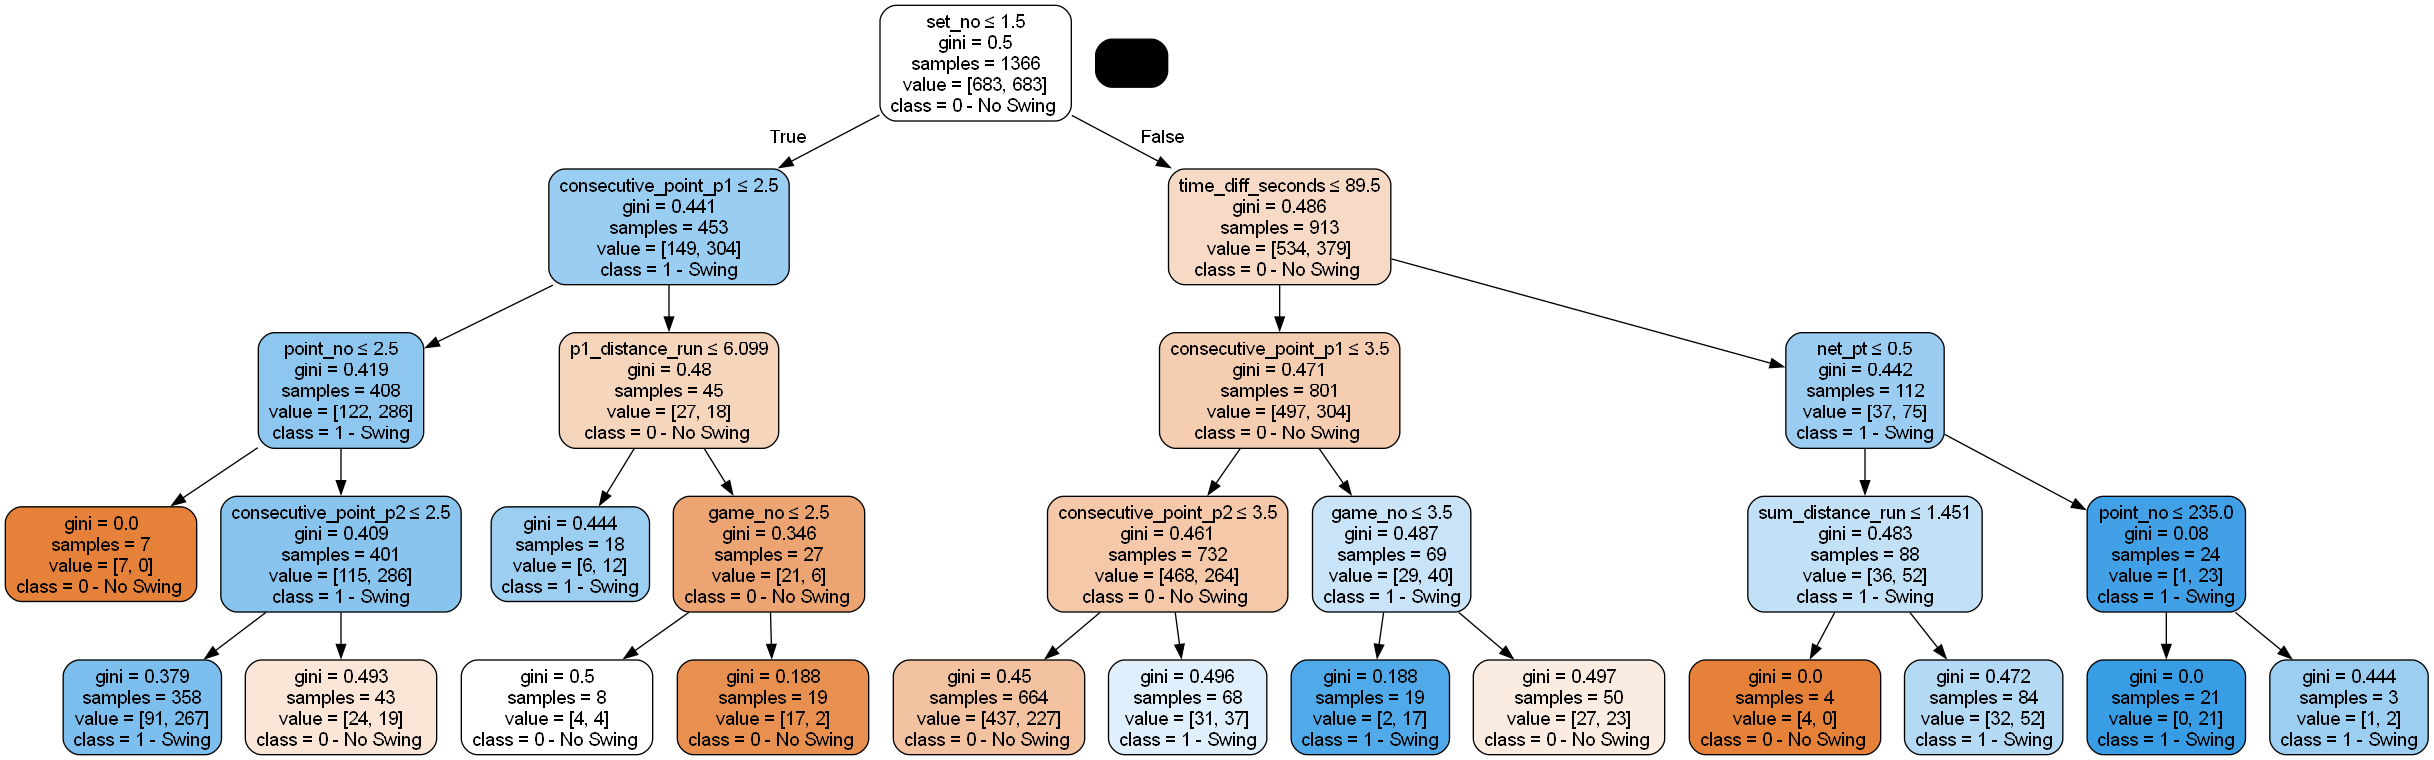

In [13]:
# Decision Tree Graph 
from sklearn.tree import export_graphviz
from io import StringIO
import pydotplus
from IPython.display import Image

class_names = ['0 - No Swing ', '1 - Swing']

dot_data = StringIO()
export_graphviz(dt_classifier, out_file=dot_data, filled=True, rounded=True,
                special_characters=True, feature_names=features, class_names=class_names)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

# Display with larger scaling
Image(graph.create_png())

In [14]:
# Classification Report
from sklearn.metrics import classification_report
y_pred = dt_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.73      0.82      1286
           1       0.24      0.64      0.35       171

    accuracy                           0.72      1457
   macro avg       0.59      0.69      0.59      1457
weighted avg       0.86      0.72      0.77      1457



In [15]:
# Feature Importances
feature_importances = dt_classifier.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(importance_df)


Feature Importances:
                 Feature  Importance
0                 set_no    0.365412
17     time_diff_seconds    0.152344
20  consecutive_point_p1    0.123367
21  consecutive_point_p2    0.111807
2               point_no    0.069838
1                game_no    0.064090
8                 net_pt    0.046893
13       p1_distance_run    0.039297
18      sum_distance_run    0.026953
27         serve_width_C    0.000000
25        serve_width_BC    0.000000
24         serve_width_B    0.000000
23    winner_shot_type_F    0.000000
28         serve_width_W    0.000000
22    winner_shot_type_B    0.000000
29       serve_depth_CTL    0.000000
30      serve_depth_NCTL    0.000000
31        return_depth_D    0.000000
26        serve_width_BW    0.000000
16             speed_mph    0.000000
19    winner_shot_type_0    0.000000
15           rally_count    0.000000
14       p2_distance_run    0.000000
12       break_pt_missed    0.000000
11          break_pt_won    0.000000
10              

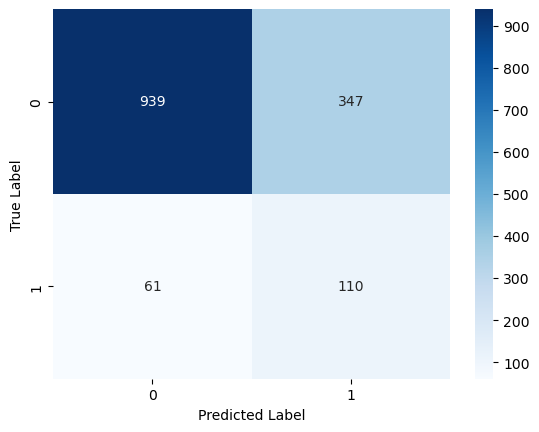

In [16]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
